# Bayesian Regression

(Example from https://pyro.ai/examples/bayesian_regression.html the dataset is not working! So use https://www.kaggle.com/datasets/budincsevity/szeged-weather/data)

In [37]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

In [39]:
def optimize(params_dict, loss_function, y, cfg, steps=500):
    optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=1)

    total_start = time()

    for i in range(steps):

        optimizer.zero_grad()  # Reset gradients
        
        # loss
        current_dist = start_SOGA(cfg, params_dict)

        loss = loss_function(y, current_dist)

        # Backpropagate
        loss.backward(retain_graph=True)
        
        optimizer.step()

        # Print progress
        if i % 10 == 0:
            out = ''
            for key in params_dict.keys():
                out = out + key + ': ' + str(params_dict[key].item()) + ' '
            out = out + f" loss: {loss.item()}"
            print(out)

    total_end = time()

    print('Optimization performed in ', round(total_end-total_start, 3))

### Linear regression (not Bayesian)

We are given a dataset $D = {(X_i, y_i)}$.

The goal of linear regression is to fit a function of the form: $$y = wX+b+\epsilon$$

where $w$ and $b$ are learnable parameters and $\epsilon$ observation noise.

tensor([0.3100, 0.3400, 0.3500, 0.3700, 0.3900, 0.3900, 0.4000, 0.4000, 0.4100,
        0.4300, 0.4600, 0.4700, 0.5100, 0.5500, 0.5700, 0.5900, 0.6000, 0.6100,
        0.6700, 0.6800, 0.7000, 0.7100, 0.7200, 0.7300, 0.7400, 0.7500, 0.7600,
        0.7700, 0.7800, 0.9200])


Text(0.5, 1.0, 'Humidity vs Apparent Temperature')

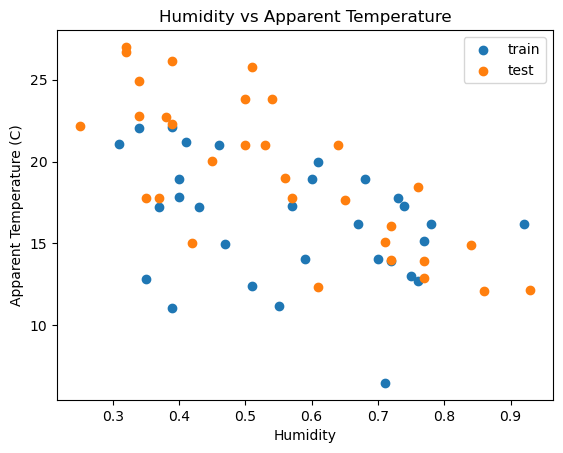

In [40]:
'''
Import the dataset
'''

weatherHistory = pd.read_csv('https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/weatherHistory.csv')
#Let's reduce the size of the dataset by considering one row for each day (corresponding to 16:00), only in 2015
#Training: April, Test: May
weatherHistory['Formatted Date'] = pd.to_datetime(weatherHistory['Formatted Date'], utc=True)
data = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 4))].reset_index(drop=True)
data_test = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 5))].reset_index(drop=True)
X = torch.tensor(data["Humidity"].to_numpy())
y = torch.tensor(data["Apparent Temperature (C)"].to_numpy())

sort_idx = np.argsort(X)

X = X[sort_idx]
y = y[sort_idx]

print(X)

plt.scatter(X, y, label = "train")
plt.scatter(data_test["Humidity"], data_test["Apparent Temperature (C)"],label = "test")
plt.legend()
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Humidity vs Apparent Temperature")

In [41]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/linear_regression.soga')
cfg = produce_cfg(compiledFile)

pars = {'w':-5., 'b':10.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

In [42]:
def mean_squared_error(y_true, dist):
    return torch.mean((y_true - dist.gm.mean()) ** 2)

def mean_squared_error_bayes(y_true, dist):
    #This works for the means but of course not for the variances
    return torch.mean((y_true - dist.gm.mean()[:-2]) ** 2)

def neg_log_likelihood(y_true, dist):
    #Calculate the log-likelihood of the data given the distribution
    log_likelihood = torch.log(dist.gm.marg_pdf(y_true.unsqueeze(0), 0))    
    return - torch.sum(log_likelihood)

In [43]:
optimize(params_dict, mean_squared_error, y, cfg)

w: -4.000000000974376 b: 10.999999999453816  loss: 95.59987242798353
w: 2.680778261553717 b: 18.013720392093624  loss: 23.254617816423508
w: -0.32484667710684334 b: 16.004087311427135  loss: 13.305686189044517
w: -1.3774024210820013 b: 16.079028344941143  loss: 14.334811983088905
w: -1.0450004937940203 b: 17.60359819806139  loss: 13.436251546325302
w: -2.6135574792392573 b: 17.27286655730318  loss: 12.584456893079308
w: -3.0037940071336995 b: 18.084543094487312  loss: 12.233726928935873
w: -3.8389723031055314 b: 18.39572699796174  loss: 12.045087391030115
w: -4.499507146076721 b: 18.793621904490948  loss: 11.903465819158434
w: -5.078222596763667 b: 19.17016507542894  loss: 11.794703375599287
w: -5.634278143352659 b: 19.458496464578474  loss: 11.715160475322646
w: -6.077958901227512 b: 19.745712075746088  loss: 11.65937531577552
w: -6.4795296506526965 b: 19.965566658398075  loss: 11.62157742081221
w: -6.801471856974659 b: 20.162174256150177  loss: 11.596771417845302
w: -7.07116551694561

Text(0.5, 1.0, 'Humidity vs Apparent Temperature')

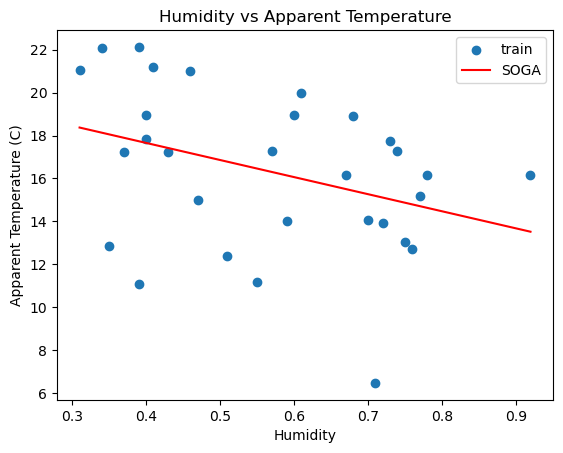

In [48]:
plt.scatter(X, y, label = "train")
plt.plot(X, params_dict['w'].detach().numpy()*X.detach().numpy()+params_dict['b'].detach().numpy(), color='red', label = "SOGA")
plt.legend()
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Humidity vs Apparent Temperature")

### Bayesian Regression

In [50]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bayesian_linear_regression.soga')
cfg = produce_cfg(compiledFile)

pars = {'muw':-10., 'mub':10., 'sigmaw':1., 'sigmab':1., 'sigmay':1.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

optimize(params_dict, neg_log_likelihood, y, cfg, steps=1000)

#predictive mean
y_pred = params_dict['muw'].detach().numpy()*X.detach().numpy()+params_dict['mub'].detach().numpy()

#predictive variance
sigma_y_pred = np.sqrt(params_dict['sigmay'].detach().numpy()**2 + (X.detach().numpy()*params_dict['sigmaw'].detach().numpy())**2 + params_dict['sigmab'].detach().numpy()**2)



muw: -9.000000000239575 mub: 10.999999999925732 sigmaw: 1.9999999998471296 sigmab: 1.999999999985309 sigmay: 1.999999999985309  loss: 767.0723608523729
muw: -4.202430344065199 mub: 15.79756965785408 sigmaw: 5.76189875152111 sigmab: 5.761898752837951 sigmay: 5.761898752837951  loss: 94.36641692348853
muw: -2.485817436098765 mub: 17.514182566911803 sigmaw: 6.823415267905336 sigmab: 6.823415269789908 sigmay: 6.823415269789908  loss: 98.10459141410085
muw: -1.8564477668643693 mub: 18.14355223665903 sigmaw: 7.137969179669066 sigmab: 7.137969181742996 sigmay: 7.137969181742996  loss: 99.65389723145759
muw: -1.7116883688426405 mub: 18.288311634818545 sigmaw: 7.159184805150267 sigmab: 7.159184807198969 sigmay: 7.159184807198969  loss: 99.8868425108177
muw: -1.7857923698288298 mub: 18.214207633749066 sigmaw: 7.053897966619756 sigmab: 7.053897968519632 sigmay: 7.053897968519632  loss: 99.50730248071733
muw: -1.951584410691095 mub: 18.048415592683824 sigmaw: 6.8869571539802585 sigmab: 6.886957155

Text(0.5, 1.0, 'Humidity vs Apparent Temperature')

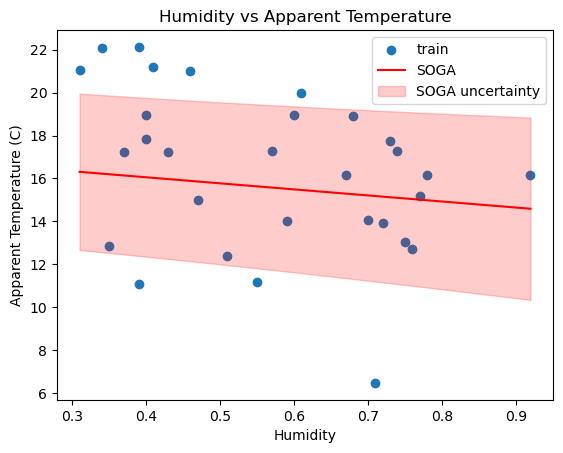

In [51]:

plt.scatter(X, y, label = "train")
plt.plot(X, y_pred, color='red', label = "SOGA")
plt.fill_between(X, y_pred - sigma_y_pred, 
                 y_pred + sigma_y_pred, 
                 color='red', alpha=0.2, label = "SOGA uncertainty")
plt.legend()
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Humidity vs Apparent Temperature")